In [52]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from tqdm import tqdm
from scipy.optimize import brentq

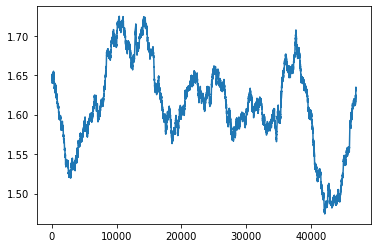

In [34]:
# Load cached data
data = np.load('../data/weather/weather-catboost.npz')
preds = data['preds']
temperatures = data['temperatures'] # Temperature (degrees Celsius)
times = data['times'] # Times

# Only take the out-of-distribution data
n_total = preds.shape[1]
preds = preds[:,n_total//2:,:]
temperatures = temperatures[n_total//2:]
times = times[n_total//2:]

pred_mean = preds[:,:,0].mean(axis=0)
pred_uncertainty = preds[:,:,1].mean(axis=0)

# Visualize the average accuracy
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

sort_idx = np.argsort(times)

accuracy_over_time = moving_average(np.abs(pred_mean[sort_idx]-temperatures[sort_idx]), 3000)


plt.plot(np.arange(accuracy_over_time.shape[0]), accuracy_over_time)
plt.show()

In [40]:
# Problem setup
alpha = 0.1 # 1-alpha is the desired coverage
K=1000; weights = np.ones((K,)); w = weights.sum() # Take a fixed window of K 

In [65]:
# Use the uncertainty scalars method to get conformal scores
scores = np.abs(pred_mean-temperatures)/pred_uncertainty
# Get the weighted score quantile at each time step
def get_weighted_quantile(scores,T):
    scores_so_far = scores[:T] #TODO: DO this more efficiently by just truncating.
    wtildes = np.concatenate([np.zeros((T-K,)),weights], axis=0)/(w+1)
    def critical_point_quantile(q): return (wtildes * scores_so_far)[scores_so_far <= q].sum() - (1 - alpha - 1/(w+1))
    return brentq(critical_point_quantile, 0, 100)

qhats = np.array( [get_weighted_quantile(scores, t) for t in range(K+1, scores.shape[0])] )
# Deploy (output=lower and upper adjusted quantiles)
prediction_sets = [pred_mean[K+1:] - pred_uncertainty[K+1:]*qhats, pred_mean[K+1:] + pred_uncertainty[K+1:]*qhats]

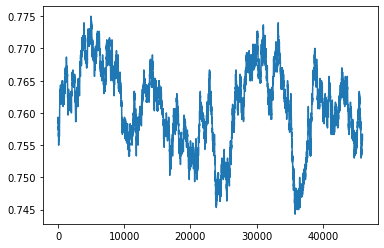

In [66]:
prediction_sets = [pred_mean[K+1:] - pred_uncertainty[K+1:]*qhats, pred_mean[K+1:] + pred_uncertainty[K+1:]*qhats]
covered = ( temperatures[K+1:] >= prediction_sets[0] ) & ( temperatures[K+1:] <= prediction_sets[1] )
coverage_over_time = moving_average(covered, 3000)
plt.plot(coverage_over_time)

In [6]:
# Calculate empirical coverage (before and after calibration)
prediction_sets_uncalibrated = [val_lower, val_upper]
empirical_coverage_uncalibrated = ((val_labels >= prediction_sets_uncalibrated[0]) & (val_labels <= prediction_sets_uncalibrated[1])).mean()
print(f"The empirical coverage before calibration is: {empirical_coverage_uncalibrated}")
empirical_coverage = ((val_labels >= prediction_sets[0]) & (val_labels <= prediction_sets[1])).mean()
print(f"The empirical coverage after calibration is: {empirical_coverage}")

The empirical coverage before calibration is: 0.7378499927462643
The empirical coverage after calibration is: 0.9305092122443058


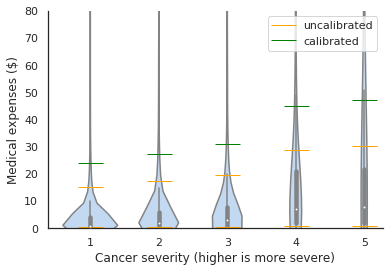

In [7]:
# Plot results stratifying across cancer severity (one of many covariates)
cancer_vecs = val_X[:,40:45]
for col in range(cancer_vecs.shape[1]):
    one_val = cancer_vecs[:,col].max()
    cancer_vecs[:,col] = (cancer_vecs[:,col] == one_val).astype(int)
cancer_dx = cancer_vecs.dot(np.arange(5)+1).astype(int)

# Trim missing labels
val_labels_trimmed = val_labels[cancer_dx > 0]
val_lower_trimmed = val_lower[cancer_dx > 0]
val_upper_trimmed = val_upper[cancer_dx > 0]
cancer_dx_trimmed = cancer_dx[cancer_dx > 0]
valid_cancer_dx = np.arange(5)+1

lower_uncal = [(np.e**(val_lower_trimmed[cancer_dx_trimmed == dx]) - 1).mean() for dx in valid_cancer_dx]
lower_cal = [(np.e**(val_lower_trimmed[cancer_dx_trimmed == dx]-qhat) - 1).mean() for dx in valid_cancer_dx]
upper_uncal = [(np.e**(val_upper_trimmed[cancer_dx_trimmed == dx]) - 1).mean() for dx in valid_cancer_dx]
upper_cal = [(np.e**(val_upper_trimmed[cancer_dx_trimmed == dx]+qhat) - 1).mean() for dx in valid_cancer_dx]

sns.set(style='white')
sns.set_palette('pastel')
plt.figure()
plt_idx = np.random.choice(np.arange(val_labels_trimmed.shape[0]), size=(val_labels_trimmed.shape[0],), replace=False)
sns.violinplot(x=cancer_dx_trimmed[plt_idx], y=np.e**val_labels_trimmed[plt_idx]-1, color='#BBD9FA')
plt.plot(valid_cancer_dx-1, lower_uncal, marker='_', markersize='25', linewidth=0, color='orange', label='uncalibrated')
plt.plot(valid_cancer_dx-1, upper_uncal, marker='_', markersize='25', linewidth=0, color='orange')
plt.plot(valid_cancer_dx-1, lower_cal, marker='_', markersize='25', linewidth=0, color='green', label='calibrated')
plt.plot(valid_cancer_dx-1, upper_cal, marker='_', markersize='25', linewidth=0, color='green')
plt.legend(loc='upper right')
plt.ylim(0,80)
plt.xlabel('Cancer severity (higher is more severe)')
plt.ylabel('Medical expenses ($)')
sns.despine(top=True,right=True)
plt.show()